In [1]:
import kdsource as kds
import kdsource.histograms as kdh
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openmc
import os
import glob
import subprocess


In [2]:
# Init trackfile
N_original = int(5e6)
source_path = "/home/lucas/Documents/Proyecto_Integrador/PI/segundo_semestre/4-7-25/sim_0/trackfile_0.h5"

# Load binning data
columns_order = ["ln(E0/E)", "x", "y", "mu", "phi"]
micro_bins = [200] * 5
macro_bins = [10, 8, 8, 7]
binning_type = "equal_bins"
user_defined_edges = [
    [2.995732273553991 + 1e-9],
    # None,
    [-1.5, 1.5],
    [-1.5, 1.5],
    [1 - 1e-9],
    None,
]

# Load z0 and particle type
z0 = 30
particle_type = "neutron"

trackfile = kdh.SurfaceTrackProcessor(source_file=source_path, N_original=N_original)
trackfile.configure_binning(
    columns=columns_order,
    micro_bins=micro_bins,
    macro_bins=macro_bins,
    binning_type=binning_type,
    user_defined_macro_edges=user_defined_edges,
)
trackfile.load_info_for_onthefly(z0=z0, particle_type=particle_type)
trackfile.save_to_xml_on_the_fly()

trackfile.load_simulation_info(
    geometria=[True, 10, 10, 10, 10, 10],
    z0=30,  # No esta mal. Antes me referia con z0 a la superficie de registro, y en esta clase z0 representa
    # la posicion de la fuente. z_track cumple la funcion de indicar donde se ubico la superficie de registro.
    fuente_original=["hola mundo"],
)

trackfile.save_to_xml("source_auxiliar.xml")

command = [
    "kdtool",
    "resample",
    "-o",
    "trackfile_resampled",
    "-n",
    str(5e6),
    "-m",
    "2",
    "/home/lucas/Documents/Proyecto_Integrador/PI/segundo_semestre/4-16-25 - test/source_auxiliar.xml",
]
# Ejecutar el comando usando subprocess
try:
    subprocess.run(command, check=True)
except subprocess.CalledProcessError as e:
    print(f"Error al ejecutar kdtool: {e}")

Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/segundo_semestre/4-7-25/sim_0/trackfile_0.h5: 2677552
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Geometria: 1.000000, 10.000000, 10.000000, 10.000000, 10.000000, 10.000000
z0: 30.000000
N_original: 5000000
fuente_original: hola mundo
columns_order: ln(E0/E), x, y, mu, phi
micro_bins: 200, 200, 200, 200, 200
macro_bins: 10, 8, 8, 7
binning_type: equal_bins
used_defined_edges: (null)
factor_normalizacion: 0.041735
Particula 100000
Particula 200000
Particula 300000
Particula 400000
Particula 500000
Particula 600000
Particula 700000
Particula 800000
Particula 900000
Particula 1000000
Particula 1100000
Particula 1200000
Particula 1300000
Particula 1400000
Particula 1500000
Particula 1600000
Particula 1700000
Particula 1800000
Particula 1900000
Particula 2000000
Particula 2100000
Particula 2200000
Particula 2300000
Particula 2400000
Particula 2500000
Particula 2600000
Particula 2700000
Particula 2800000
Particula 2900000
Partic

In [3]:
# ---------------------------------------------------------------------------------------------------------------------------------------
# Configuración de secciones eficaces
# ---------------------------------------------------------------------------------------------------------------------------------------
openmc.config["cross_sections"] = (
    "/home/lucas/Documents/Proyecto_Integrador/endfb-viii.0-hdf5/cross_sections.xml"
)

# ----------------------------------------------------------------------------------------------------------------------------------------
# Procesamiento de la fuente
# ----------------------------------------------------------------------------------------------------------------------------------------
source = openmc.HistogramSource(path = "/home/lucas/Documents/Proyecto_Integrador/PI/segundo_semestre/4-16-25 - test/source.xml")

# ---------------------------------------------------------------------------------------------------------------------------------------
# Procesamiento de la geometría
# ---------------------------------------------------------------------------------------------------------------------------------------
# Parámetros geométricos
L_x, L_y, L_z = 15,15,z0+10.025

# Definir superficies externas
surfaces = {
    "x_min": openmc.XPlane(x0=-L_x / 2, boundary_type="vacuum"),
    "x_max": openmc.XPlane(x0=L_x / 2, boundary_type="vacuum"),
    "y_min": openmc.YPlane(y0=-L_y / 2, boundary_type="vacuum"),
    "y_max": openmc.YPlane(y0=L_y / 2, boundary_type="vacuum"),
    "z_min": openmc.ZPlane(z0=z0, boundary_type="vacuum"),
    "z_max": openmc.ZPlane(z0=L_z, boundary_type="vacuum"),
}

# Se agrega la superficie de registro para generar el track file
surfaces.update(
    {
        "z_track": openmc.ZPlane(
            z0=L_z-10, boundary_type="transmission", surface_id=70
        )
    }
)

# Para fuente tipo FileSource se traduce la superficie inferior para posicionar z0.
# Sino se hace entonces las particulas aparecer fuera de la geometria.
surfaces["z_min"].translate(vector=(0, 0, -1e-6), inplace=True)

# Definir regiones
region_externa = (
    +surfaces["x_min"]
    & -surfaces["x_max"]
    & +surfaces["y_min"]
    & -surfaces["y_max"]
    & +surfaces["z_min"]
    & -surfaces["z_max"]
)

# Crear universo y definir celdas según configuración de fuente y vacío
universe = openmc.Universe()

universe.add_cell(
    openmc.Cell(
        region=region_externa & -surfaces["z_track"],
        fill=None,
        name="region1",
    )
)
universe.add_cell(
    openmc.Cell(
        region=region_externa & +surfaces["z_track"],
        fill=None,
        name="region2",
    )
)

geom = openmc.Geometry(universe)
geom.export_to_xml()

# ---------------------------------------------------------------------------------------------------------------------------------------
# Configuración de settings
# ---------------------------------------------------------------------------------------------------------------------------------------
settings = openmc.Settings()
settings.surf_source_write = {"surface_ids": [70], "max_particles": 20000000}
settings.run_mode = "fixed source"
settings.batches = 100
settings.particles = int(5e4)
settings.source = source
settings.export_to_xml()

# ---------------------------------------------------------------------------------------------------------------------------------------
# Limpieza de archivos previos y ejecución de la simulación
# ---------------------------------------------------------------------------------------------------------------------------------------
for file in glob.glob("statepoint.*.h5"):
    os.remove(file)
if os.path.exists("summary.h5"):
    os.remove("summary.h5")

openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [4]:
vector_x = np.linspace(-7.5, 7.5, 200)
vector_y = np.linspace(-7.5, 7.5, 200)
vector_u = np.linspace(0, 30, 200)
vector_phi = np.linspace(-4, 4, 200)
vector_mu = np.linspace(0, 1, 200)

# ---------------------------------------------------------------------------------------------------------------------------------------

df_original = kds.SurfaceSourceFile("/home/lucas/Documents/Proyecto_Integrador/PI/segundo_semestre/4-16-25 - test/trackfile_resampled.mcpl.gz").get_pandas_dataframe()
valores_x = df_original["x"].to_numpy()
valores_y = df_original["y"].to_numpy()
valores_u = df_original["ln(E0/E)"].to_numpy()
valores_phi = df_original["phi"].to_numpy()
valores_mu = df_original["mu"].to_numpy()
del df_original

hist_x_original = np.histogram(valores_x, bins=vector_x)[0]
hist_y_original = np.histogram(valores_y, bins=vector_y)[0]
hist_u_original = np.histogram(valores_u, bins=vector_u)[0]
hist_phi_original = np.histogram(valores_phi, bins=vector_phi)[0]
hist_mu_original = np.histogram(valores_mu, bins=vector_mu)[0]
del valores_x, valores_y, valores_u, valores_phi, valores_mu

# ---------------------------------------------------------------------------------------------------------------------------------------

df_registrado = kds.SurfaceSourceFile(
    "/home/lucas/Documents/Proyecto_Integrador/PI/segundo_semestre/4-16-25 - test/surface_source.h5"
).get_pandas_dataframe()
valores_x = df_registrado["x"].to_numpy()
valores_y = df_registrado["y"].to_numpy()
valores_u = df_registrado["ln(E0/E)"].to_numpy()
valores_phi = df_registrado["phi"].to_numpy()
valores_mu = df_registrado["mu"].to_numpy()
del df_registrado

hist_x_registrado = np.histogram(valores_x, bins=vector_x)[0]
hist_y_registrado = np.histogram(valores_y, bins=vector_y)[0]
hist_u_registrado = np.histogram(valores_u, bins=vector_u)[0]
hist_phi_registrado = np.histogram(valores_phi, bins=vector_phi)[0]
hist_mu_registrado = np.histogram(valores_mu, bins=vector_mu)[0]
del valores_x, valores_y, valores_u, valores_phi, valores_mu

Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/segundo_semestre/4-16-25 - test/trackfile_resampled.mcpl.gz: 5000000
100% n, 0% g, 0% e-, 0% e+, 0% p, 


/home/lucas/anaconda3/envs/proyecto_integrador/lib/python3.10/site-packages/kdsource/surfsource.py:437: RuntimeWarning: divide by zero encountered in log10
  df["log(t)"] = np.log10(df["t"].to_numpy())
/home/lucas/anaconda3/envs/proyecto_integrador/lib/python3.10/site-packages/kdsource/surfsource.py:437: RuntimeWarning: divide by zero encountered in log10
  df["log(t)"] = np.log10(df["t"].to_numpy())


Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/segundo_semestre/4-16-25 - test/surface_source.h5: 4999983
100% n, 0% g, 0% e-, 0% e+, 0% p, 


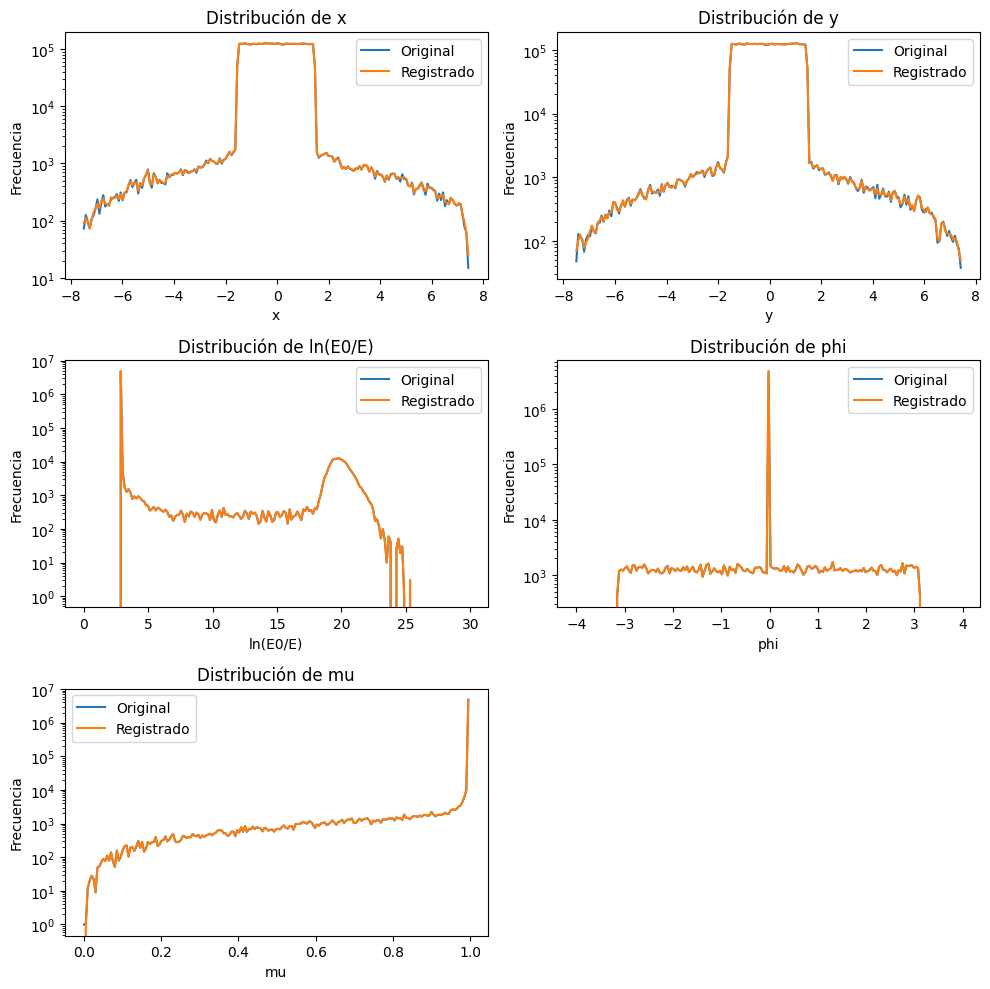

In [5]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1)
plt.plot(vector_x[:-1], hist_x_original, label="Original")
plt.plot(vector_x[:-1], hist_x_registrado, label="Registrado")
plt.title("Distribución de x")
plt.xlabel("x")
plt.ylabel("Frecuencia")
plt.yscale("log")
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(vector_y[:-1], hist_y_original, label="Original")
plt.plot(vector_y[:-1], hist_y_registrado, label="Registrado")
plt.title("Distribución de y")
plt.xlabel("y")
plt.ylabel("Frecuencia")
plt.yscale("log")
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(vector_u[:-1], hist_u_original, label="Original")
plt.plot(vector_u[:-1], hist_u_registrado, label="Registrado")
plt.title("Distribución de ln(E0/E)")
plt.xlabel("ln(E0/E)")
plt.ylabel("Frecuencia")
plt.yscale("log")
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(vector_phi[:-1], hist_phi_original, label="Original")
plt.plot(vector_phi[:-1], hist_phi_registrado, label="Registrado")
plt.title("Distribución de phi")
plt.xlabel("phi")
plt.ylabel("Frecuencia")
plt.yscale("log")
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(vector_mu[:-1], hist_mu_original, label="Original")
plt.plot(vector_mu[:-1], hist_mu_registrado, label="Registrado")
plt.title("Distribución de mu")
plt.xlabel("mu")
plt.ylabel("Frecuencia")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.savefig("distribuciones.png")
plt.show()
plt.close()